In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import json
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from scipy.stats import bernoulli

sns.set_context("paper", font_scale=1.5)

In [2]:
cmap = sns.color_palette("Set2")
cmap

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [3]:
COMBINATIONS = [
("Staphylococcus aureus", "Ciprofloxacin"),
("Klebsiella pneumoniae", "Meropenem"),
("Klebsiella pneumoniae", "Ciprofloxacin"),
("Escherichia coli", "Tobramycin"),
("Klebsiella pneumoniae", "Tobramycin"),
("Escherichia coli", "Cefepime"),
("Escherichia coli", "Ceftriaxone"),
("Escherichia coli", "Ciprofloxacin"),
("Klebsiella pneumoniae", "Cefepime"),
("Klebsiella pneumoniae", "Ceftriaxone"),
("Staphylococcus aureus", "Fusidic acid"),
("Staphylococcus aureus", "Oxacillin")
]


In [4]:
baseline_results = { #AUROC, AUPRC
("Staphylococcus aureus", "Ciprofloxacin"): (0.72, 0.43),
("Klebsiella pneumoniae", "Meropenem"): (0.55, 0.16),
("Klebsiella pneumoniae", "Ciprofloxacin"): (0.68, 0.31),
("Escherichia coli", "Tobramycin"): (0.64, 0.18),
("Klebsiella pneumoniae", "Tobramycin"): (0.74, 0.29),
("Escherichia coli", "Cefepime"): (0.73, 0.24),
("Escherichia coli", "Ceftriaxone"): (0.74, 0.30),
("Escherichia coli", "Ciprofloxacin"): (0.76, 0.60),
("Klebsiella pneumoniae", "Cefepime"):  (0.76, 0.31),
("Klebsiella pneumoniae", "Ceftriaxone"): (0.74, 0.33),
("Staphylococcus aureus", "Fusidic acid"): (0.65, 0.13),
("Staphylococcus aureus", "Oxacillin"): (0.80, 0.49)
}

In [5]:
species_list = np.unique([c[0] for c in COMBINATIONS])
species_list

array(['Escherichia coli', 'Klebsiella pneumoniae',
       'Staphylococcus aureus'], dtype='<U21')

In [6]:
all_drugs = sorted(np.unique([c[1] for c in COMBINATIONS]))
all_drugs

['Cefepime',
 'Ceftriaxone',
 'Ciprofloxacin',
 'Fusidic acid',
 'Meropenem',
 'Oxacillin',
 'Tobramycin']

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

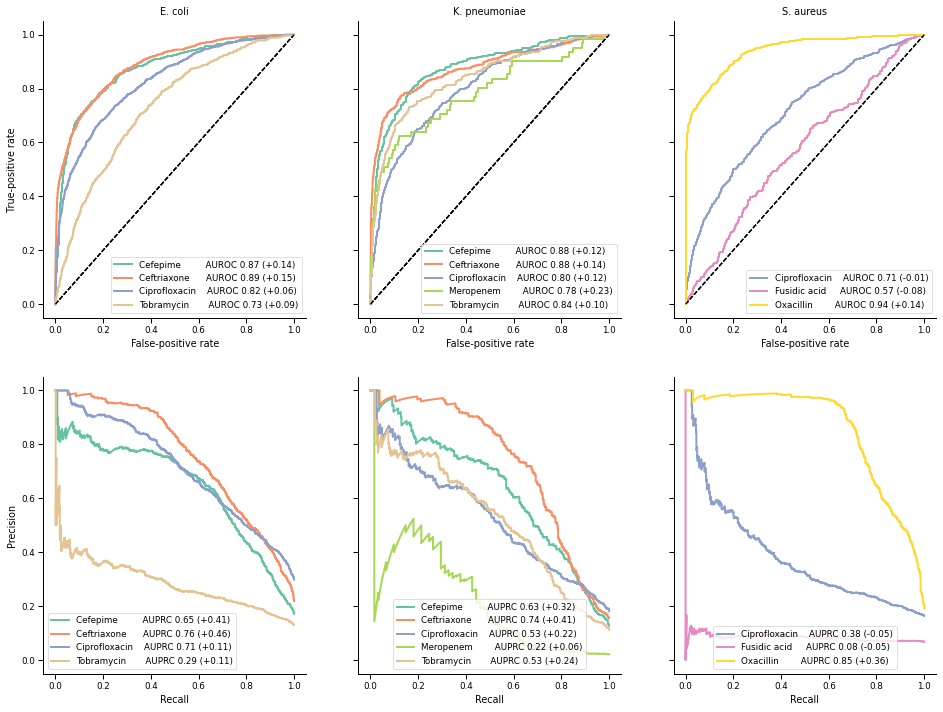

In [7]:
sns.set_context("paper", font_scale=1.0)
fig, axs = plt.subplots(2, 3, figsize=(16, 12), sharex=False, sharey=True)


for j, sp in enumerate(species_list):
    
    drugs = sorted([c[1] for c in COMBINATIONS if c[0]==sp])
    len_pad = max([len(d) for d in drugs]) + 4

    # fig, ax = plt.subplots(figsize=(8,8))
    for i, drug in tqdm(enumerate(drugs)):
        df = None
        for n_split in range(5):
            try:
                split_df = pd.read_csv(f"outputs/PaperComparison/ResAMR_comp_full_/predictions/{sp}_{drug}/split_{n_split}.csv")
                # split_df = pd.read_csv(f"outputs/baseline_comp_2018/resMLP_finetune_2018/predictions/{sp}_{drug}/split_{n_split}.csv")
            except:
                continue
            if df is None:
                df = split_df
            else:
                df = pd.concat([df, split_df])
        if df is None:
            continue
            
        ix = all_drugs.index(drug)
        # df["predicted_proba"] += df["response"]*bernoulli.rvs(0.2, size=len(df), random_state=42)*df["predicted_proba"].median()/2
        
        baseline_auroc, baseline_auprc = baseline_results[(sp, drug)]
        
        pad_space = len_pad - len(drug)
        fpr, tpr, thresh = roc_curve(df["response"], df["predicted_proba"])
        roc_score = auc(fpr, tpr)
        # axs[0,j].plot(fpr, tpr, label=[drug,"AUROC {:.2f}".format(roc_score)].ljust(16))
        
        delta_auroc = roc_score - baseline_auroc
        axs[0,j].plot(fpr, tpr, color=cmap[ix], label=drug.ljust(len_pad)+ "AUROC {:.2f} ({:+.2f})".format(roc_score, delta_auroc).rjust(15), linewidth=2)
        axs[0,j].plot([0,1], [0,1],linestyle="dashed", color="black")
        
        precision, recall, thresholds = precision_recall_curve(df["response"], df["predicted_proba"])
        auprc = auc(recall, precision)
        delta_auprc = auprc - baseline_auprc
        
        axs[1,j].plot(recall, precision, color=cmap[ix], label=drug+ " "*pad_space+ "AUPRC {:.2f} ({:+.2f})".format(auprc, delta_auprc), linewidth=2)
        sns.despine()
        
        df.to_csv("/home/gvisona/Desktop/ROC_curves/{}_{}.csv".format(sp.replace(" ", "_"), drug), index=False)
    axs[0,j].legend()
    axs[1,j].legend()
    title_label = sp[0] + ". " + sp.split(" ")[-1]
    axs[0,j].set_title(f"{title_label}")
        
axs[0,0].set_ylabel("True-positive rate")
axs[1,0].set_ylabel("Precision")
for i in range(3):
    axs[0,i].set_xlabel("False-positive rate")
    axs[1,i].set_xlabel("Recall")

axs[1,1].legend(loc="lower center")
axs[1,2].legend(loc="lower center")
fig.savefig("outputs/plots/roc_curves_A.pdf", bbox_inches="tight")
plt.show()
plt.close(fig)


## Plot individual curves

In [8]:
sns.set_context("paper", font_scale=1.5)

In [15]:
resmlp_aurocs = {}
resmlp_auprcs = {}

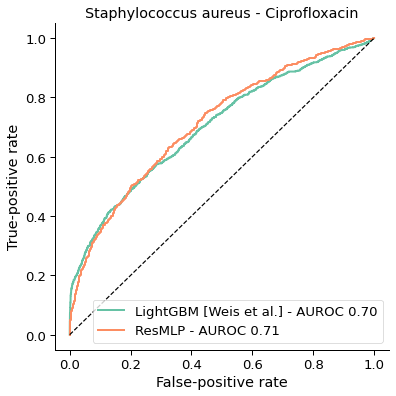

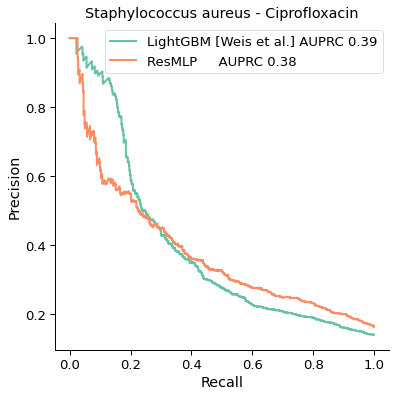

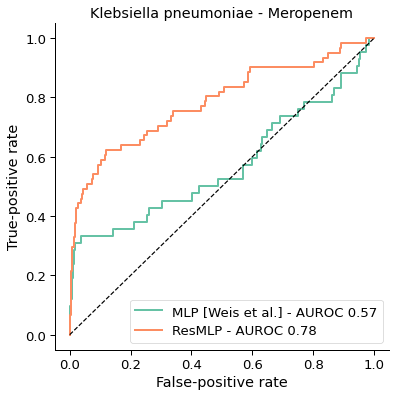

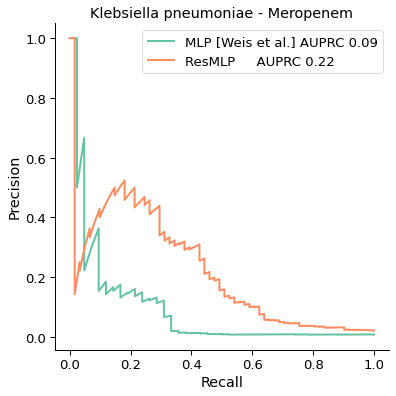

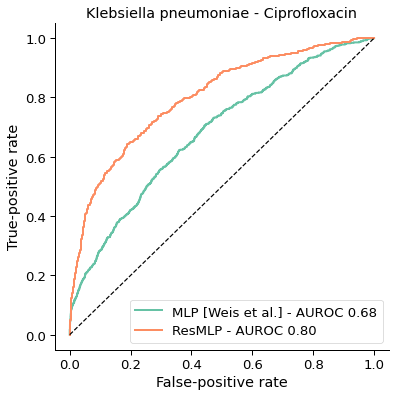

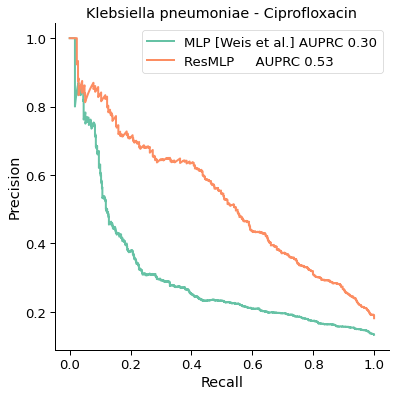

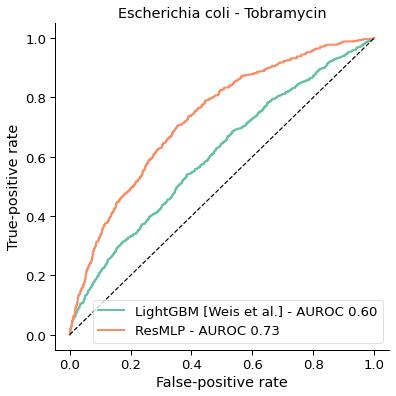

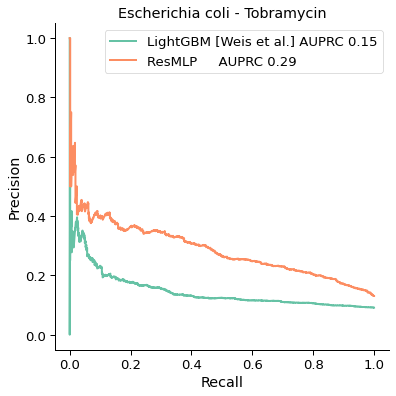

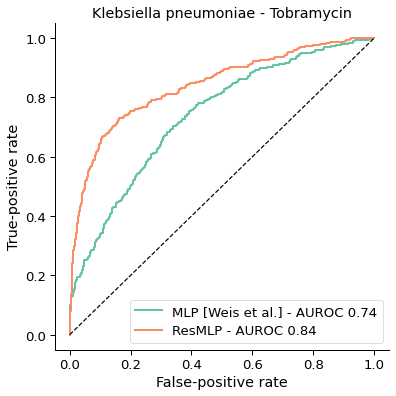

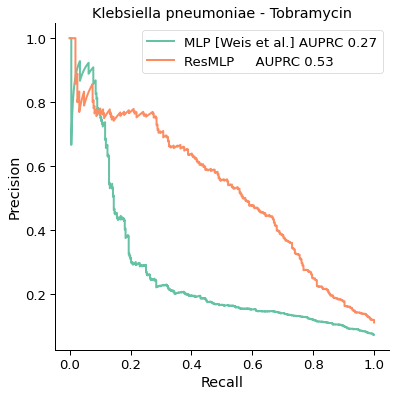

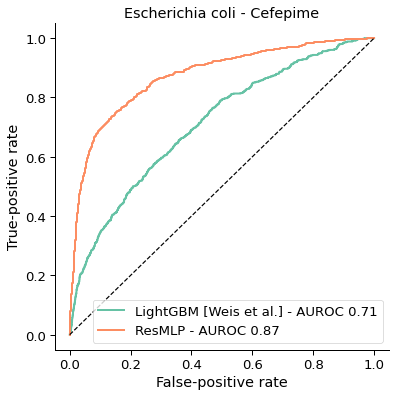

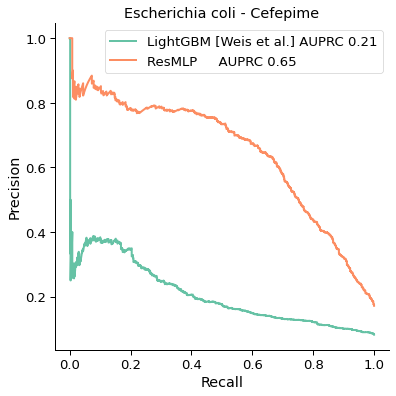

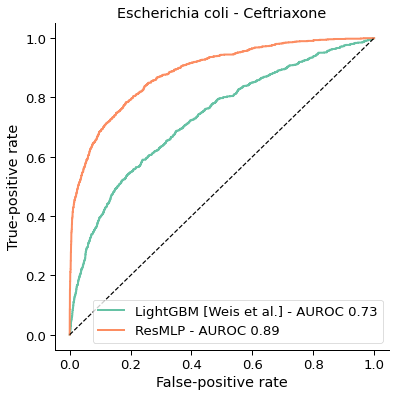

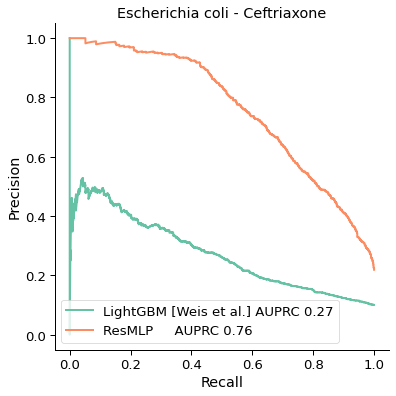

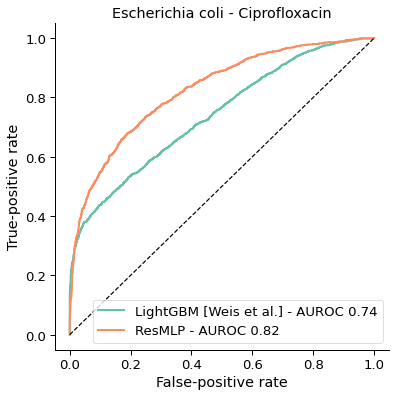

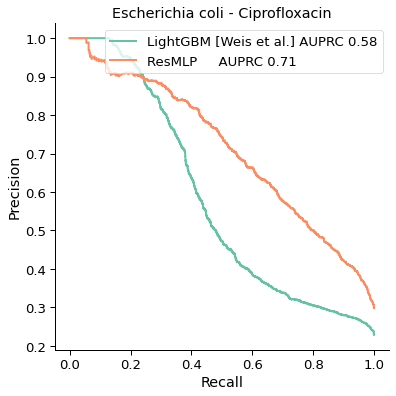

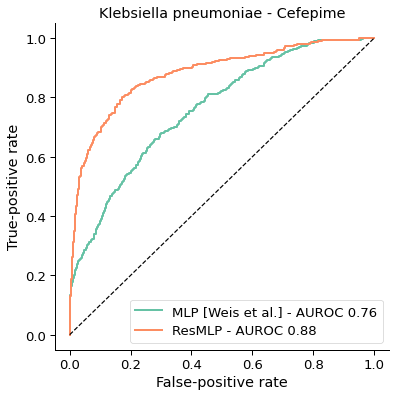

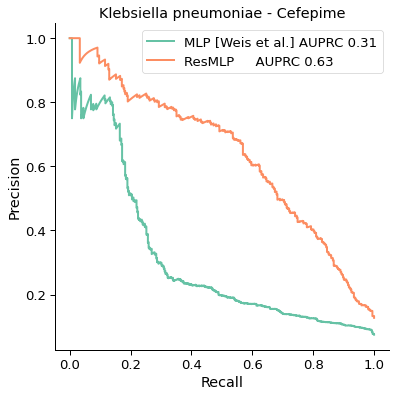

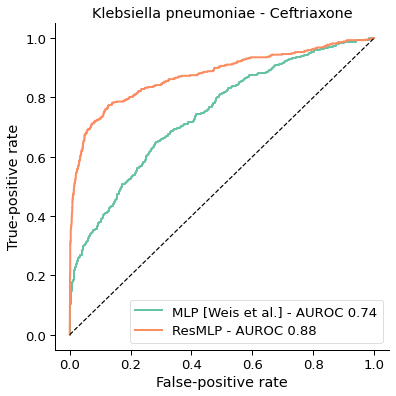

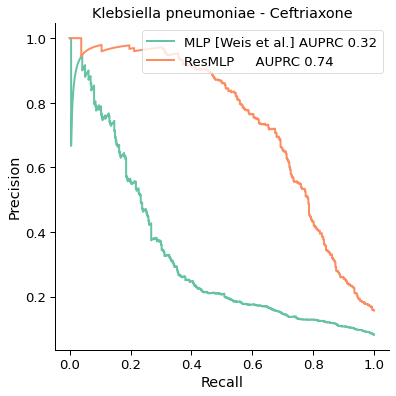

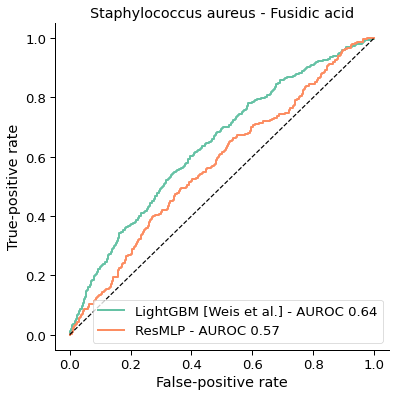

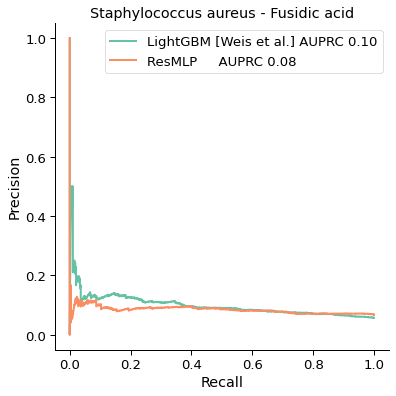

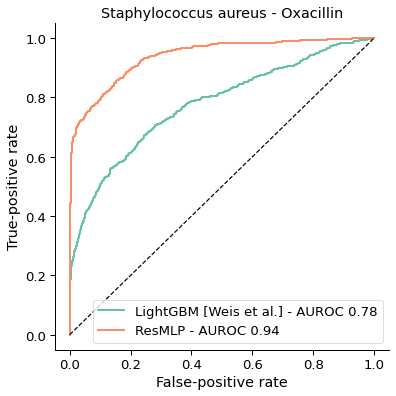

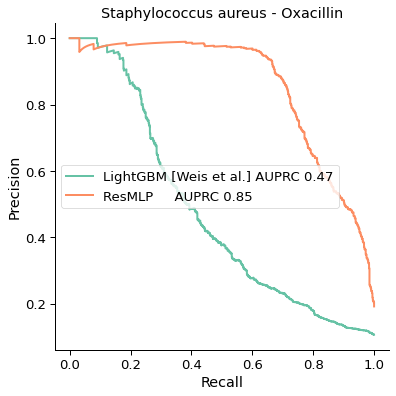

In [16]:
# baseline_model = "lightgbm"

# sp = "Escherichia coli"
# drug = "Cefepime"

baselines_figure_mapping = {
    "Escherichia coli": "lightgbm",
    "Klebsiella pneumoniae": "mlp",
    "Staphylococcus aureus": "lightgbm",
}

model_labels = {
    "lightgbm": "LightGBM",
    "mlp": "MLP"
}


delta_aurocs = {}
delta_auprcs = {}
for sp, drug in COMBINATIONS:
    
    
    # if (sp!= "Klebsiella pneumoniae") or (drug != "Meropenem"):
    #     continue
    baseline_model = baselines_figure_mapping[sp]
    baseline_results_folder = "../data/curves_per_species_and_antibiotics_case_based_stratification/{}".format(baseline_model)
    
    baseline_data = []
    
    for fname in os.listdir(baseline_results_folder):
        if sp.replace(" ", "_") in fname and drug.replace(" ", "_") in fname:
            # print(fname)
            with open(os.path.join(baseline_results_folder, fname), "r") as f: 
                baseline_data.append(json.load(f))
        
    
    bl_y_score = []
    bl_y_test = []
    for seed_split in baseline_data:
        bl_y_score.extend(np.array(seed_split["y_score"])[:,1].tolist())
        bl_y_test.extend(seed_split["y_test"])
            
    df = pd.read_csv("/home/gvisona/Desktop/ROC_curves/{}_{}.csv".format(sp.replace(" ", "_"), drug))
    
    
    
    
    # AUROC
    fig, ax = plt.subplots(figsize=(6,6))
    # Baseline data
    
    bl_fpr, bl_tpr, bl_thresh = roc_curve(bl_y_test, bl_y_score)
    bl_roc_score = auc(bl_fpr, bl_tpr)
    
    # bl_precision, bl_recall, bl_thresholds = precision_recall_curve(bl_y_test, bl_y_score)
    # bl_auprc = auc(bl_recall, bl_precision)
    
    fpr, tpr, thresh = roc_curve(df["response"], df["predicted_proba"])
    roc_score = auc(fpr, tpr)
    resmlp_aurocs[(sp, drug)] = roc_score
    
    ax.plot(bl_fpr, bl_tpr, color=cmap[0], label=model_labels[baseline_model] + " [Weis et al.]" + " - AUROC {:.2f}".format(bl_roc_score), linewidth=2)
    ax.plot(fpr, tpr, color=cmap[1], label="ResMLP" + " - AUROC {:.2f}".format(roc_score), linewidth=2)#.rjust(15),
    ax.plot([0,1], [0,1],linestyle="dashed", color="black")
    
    ax.set_title("{} - {}".format(sp, drug))
    delta_auroc = roc_score - bl_roc_score
    # c = "green" if delta_auroc>=0 else "red"
    # ax.text(0.5, 0.3, "Δ AUROC = {:+.2f}".format(delta_auroc), color=c)
    
    ax.legend(loc="lower right")
    ax.set_ylabel("True-positive rate")
    ax.set_xlabel("False-positive rate")

    sns.despine()
    plt.show()
    
    # fig.savefig("outputs/plots/baseline_comparisons/ROC/ROC_ResMLP_vs_{}-{}_{}.png".format(baseline_model, sp, drug), facecolor="white", dpi=200)
    fig.savefig("outputs/plots/baseline_comparisons/ROC/ROC_ResMLP_vs_{}-{}_{}.pdf".format(baseline_model, sp, drug), bbox_inches="tight")
    plt.close(fig)
    
    
    delta_aurocs[(sp, drug)] = roc_score - bl_roc_score
    # AUPRC
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    bl_precision, bl_recall, bl_thresholds = precision_recall_curve(bl_y_test, bl_y_score)
    bl_auprc = auc(bl_recall, bl_precision)
    
    precision, recall, thresholds = precision_recall_curve(df["response"], df["predicted_proba"])
    auprc = auc(recall, precision)
    
    resmlp_auprcs[(sp, drug)] = auprc

    delta_auprc = auprc - bl_auprc
        
    baseline_label = model_labels[baseline_model] + " [Weis et al.]"
    ax.plot(bl_recall, bl_precision, color=cmap[0], label= baseline_label +  " AUPRC {:.2f}".format(bl_auprc), linewidth=2)
    padding = len(baseline_label)-6
    ax.plot(recall, precision, color=cmap[1], label="ResMLP"  + " AUPRC {:.2f}".format(auprc).rjust(15), linewidth=2)
    # ax.plot([0,1], [0,1],linestyle="dashed", color="black")
    
    ax.set_title("{} - {}".format(sp, drug))
    c = "green" if delta_auprc>=0 else "red"
    # ax.text(0.6, 0.98, "Δ AUPRC = {:+.2f}".format(delta_auprc), color=c)
    
    ax.legend()#(loc="lower left")
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")

    sns.despine()
    plt.show()
    
    # fig.savefig("outputs/plots/baseline_comparisons/PRC/PRC_ResMLP_vs_{}-{}_{}.png".format(baseline_model, sp, drug), facecolor="white", dpi=200)
    fig.savefig("outputs/plots/baseline_comparisons/PRC/PRC_ResMLP_vs_{}-{}_{}.pdf".format(baseline_model, sp, drug), bbox_inches="tight")
    plt.close(fig)
    
    delta_auprcs[(sp, drug)] = delta_auprc
    
    


In [10]:
data = []

for sp, drug in COMBINATIONS:
    data.append({"species": sp, "drug": drug, "delta_auroc": delta_aurocs[(sp, drug)], "delta_auprc": delta_auprcs[(sp, drug)]})
    
delta_df = pd.DataFrame(data)
delta_df

,species,drug,delta_auroc,delta_auprc
0,Staphylococcus aureus,Ciprofloxacin,0.010794,-0.011724
1,Klebsiella pneumoniae,Meropenem,0.214466,0.127411
2,Klebsiella pneumoniae,Ciprofloxacin,0.119068,0.230691
3,Escherichia coli,Tobramycin,0.126209,0.140555
4,Klebsiella pneumoniae,Tobramycin,0.102099,0.257026
5,Escherichia coli,Cefepime,0.161919,0.440867
6,Escherichia coli,Ceftriaxone,0.154570,0.488003
7,Escherichia coli,Ciprofloxacin,0.085767,0.130890
8,Klebsiella pneumoniae,Cefepime,0.118415,0.326406
9,Klebsiella pneumoniae,Ceftriaxone,0.132583,0.415683


In [11]:
delta_df.sort_values(by="delta_auroc")

,species,drug,delta_auroc,delta_auprc
10,Staphylococcus aureus,Fusidic acid,-0.067369,-0.014752
0,Staphylococcus aureus,Ciprofloxacin,0.010794,-0.011724
7,Escherichia coli,Ciprofloxacin,0.085767,0.130890
4,Klebsiella pneumoniae,Tobramycin,0.102099,0.257026
8,Klebsiella pneumoniae,Cefepime,0.118415,0.326406
2,Klebsiella pneumoniae,Ciprofloxacin,0.119068,0.230691
3,Escherichia coli,Tobramycin,0.126209,0.140555
9,Klebsiella pneumoniae,Ceftriaxone,0.132583,0.415683
6,Escherichia coli,Ceftriaxone,0.154570,0.488003
5,Escherichia coli,Cefepime,0.161919,0.440867


In [12]:
driams_long_table[

SyntaxError: unexpected EOF while parsing (<ipython-input-12-0181a14581e0>, line 1)

In [13]:
fpr, tpr, thresh = roc_curve(baseline_data["y_test"], np.array(baseline_data["y_score"])[:,1])
roc_score = auc(fpr, tpr)
roc_score


TypeError: list indices must be integers or slices, not str

In [14]:
baseline_data["prevalence_train"]

TypeError: list indices must be integers or slices, not str

In [15]:
df.drop_duplicates(["sample_id", "drug"])

,species,sample_id,drug,response,dataset,predicted_proba
0,Staphylococcus aureus,49eceea6-f184-4ed2-9cf6-e6d411c47f85,Oxacillin,0,A,0.000003
1,Staphylococcus aureus,e2944974-79cf-4457-b042-f56a42fb717c,Oxacillin,1,A,0.922907
2,Staphylococcus aureus,6cab683a-cc5f-47c6-8b10-18e117ccf932,Oxacillin,0,A,0.000139
3,Staphylococcus aureus,a2167137-4f68-4034-8376-dd25936ad094,Oxacillin,0,A,0.004843
4,Staphylococcus aureus,d5bd8e2b-8fcb-4151-8856-c82390f5c4d2,Oxacillin,0,A,0.002091
...,...,...,...,...,...,...
3785,Staphylococcus aureus,ffd2f70e-a502-4ded-bf1f-fc0a8523c713,Oxacillin,0,A,0.771603
3786,Staphylococcus aureus,79943a08-64ef-4296-a8b8-527d664ae2d3,Oxacillin,0,A,0.341713
3787,Staphylococcus aureus,f8656149-7afa-4b5e-a8fe-b8d9f3a65edd,Oxacillin,0,A,0.877364
3788,Staphylococcus aureus,d58361f8-a500-4dfa-9aaa-493ffbe07fa3,Oxacillin,0,A,0.652807


In [16]:
len(baseline_data["y_test"])

TypeError: list indices must be integers or slices, not str

# Eval metrics

In [17]:
from sklearn.metrics import matthews_corrcoef, accuracy_score, balanced_accuracy_score, f1_score, average_precision_score
from sklearn.metrics import precision_score, recall_score

In [86]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [105]:
metrics_results=[]
for sp, drug in COMBINATIONS:
    df = pd.read_csv("/home/gvisona/Desktop/ROC_curves_A2018/{}_{}.csv".format(sp.replace(" ", "_"), drug))
    y_target = df["response"].values
    y_pred = sigmoid(df["predicted_logits"].values)
    precision, recall, thresholds = precision_recall_curve(y_target, y_pred)

    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    thr = thresholds[ix]
    thr = 0.5
    y_pred_class = (y_pred>=thr).astype(int)
    # print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    res = {"drug": drug, "species": sp}
    logs = {
            "mcc": matthews_corrcoef(y_target, y_pred_class),
            "balanced_accuracy": balanced_accuracy_score(y_target, y_pred_class),
            "f1": f1_score(y_target, y_pred_class, zero_division=0),
            "AUPRC": average_precision_score(y_target, y_pred),
            "precision": precision_score(y_target, y_pred_class, zero_division=0),
            "recall": recall_score(y_target, y_pred_class, zero_division=0),
        }
    res.update(logs)
    metrics_results.append(res)
metrics_results= pd.DataFrame(metrics_results)
metrics_results.to_csv("/home/gvisona/Desktop/ROC_curves_A2018/metrics.csv")
metrics_results

<ipython-input-105-bcaebff52b22>:9: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


,drug,species,mcc,balanced_accuracy,f1,AUPRC,precision,recall
0,Ciprofloxacin,Staphylococcus aureus,0.0,0.5,0.281905,0.355372,0.164080,1.0
1,Meropenem,Klebsiella pneumoniae,0.0,0.5,0.042006,0.045600,0.021454,1.0
2,Ciprofloxacin,Klebsiella pneumoniae,0.0,0.5,0.306177,0.392681,0.180761,1.0
3,Tobramycin,Escherichia coli,0.0,0.5,0.230955,0.153828,0.130554,1.0
4,Tobramycin,Klebsiella pneumoniae,0.0,0.5,0.201159,0.360207,0.111827,1.0
5,Cefepime,Escherichia coli,0.0,0.5,0.293194,0.434543,0.171779,1.0
6,Ceftriaxone,Escherichia coli,0.0,0.5,0.359186,0.480390,0.218907,1.0
7,Ciprofloxacin,Escherichia coli,0.0,0.5,0.459820,0.526067,0.298549,1.0
8,Cefepime,Klebsiella pneumoniae,0.0,0.5,0.226386,0.376873,0.127641,1.0
9,Ceftriaxone,Klebsiella pneumoniae,0.0,0.5,0.271250,0.463514,0.156906,1.0


In [100]:
recall

array([1.        , 0.99770115, 0.99770115, ..., 0.0045977 , 0.00229885,
       0.        ])

In [106]:
y_pred

array([0.50000012, 0.51752944, 0.50000091, ..., 0.72984469, 0.51124573,
       0.52884388])

In [70]:
driams_long_table = pd.read_csv("../processed_data/DRIAMS_combined_long_table.csv")
driams_long_table

,species,sample_id,drug,response,dataset
0,Staphylococcus epidermidis,e9adf43d-679b-497c-9849-1fa214838dd3,Meropenem,1,A
1,Staphylococcus epidermidis,e9adf43d-679b-497c-9849-1fa214838dd3,Ciprofloxacin,1,A
2,Staphylococcus epidermidis,e9adf43d-679b-497c-9849-1fa214838dd3,Cefepime,1,A
3,Staphylococcus epidermidis,e9adf43d-679b-497c-9849-1fa214838dd3,Cotrimoxazole,0,A
4,Staphylococcus epidermidis,e9adf43d-679b-497c-9849-1fa214838dd3,Imipenem,1,A
...,...,...,...,...,...
652766,Staphylococcus aureus,08bc8410-51ec-46d7-ac7b-afba9e6ba2cd_3313,Linezolid,0,D
652767,Staphylococcus aureus,08bc8410-51ec-46d7-ac7b-afba9e6ba2cd_3313,Rifampicin,0,D
652768,Staphylococcus aureus,08bc8410-51ec-46d7-ac7b-afba9e6ba2cd_3313,Tetracycline,0,D
652769,Staphylococcus aureus,08bc8410-51ec-46d7-ac7b-afba9e6ba2cd_3313,Tigecycline,0,D


In [139]:
driams_long_table[(driams_long_table["dataset"]=="A")&(driams_long_table["species"]==sp)&(driams_long_table["drug"]==drug)]

,species,sample_id,drug,response,dataset
482,Klebsiella pneumoniae,240545db-4a4e-4cca-aa88-c5016389d2d4,Meropenem,0,A
629,Klebsiella pneumoniae,e51f63f7-c21c-4d17-97f4-76aec31494a4,Meropenem,0,A
967,Klebsiella pneumoniae,43dc2b3a-070a-4e06-93a6-ba35a9351d5f,Meropenem,0,A
1057,Klebsiella pneumoniae,56ce08d4-e651-4263-a3fa-28ee2efe0229,Meropenem,0,A
1319,Klebsiella pneumoniae,d14acd77-6a76-4976-b489-02f39ee3c165,Meropenem,0,A
...,...,...,...,...,...
404593,Klebsiella pneumoniae,750d4775-e2fb-4c68-a9ed-c66863ad0ae2,Meropenem,0,A
404607,Klebsiella pneumoniae,5828ea1d-0f00-49db-a88e-8f991b790d68,Meropenem,0,A
404621,Klebsiella pneumoniae,e0bb20c1-2f5b-4e14-8cff-f6ab1450e285,Meropenem,0,A
404647,Klebsiella pneumoniae,8bfc1aeb-7f18-4668-80e6-cda4a03e650f,Meropenem,0,A


# Fusidic check

In [24]:
fa_df = pd.read_csv("outputs/ResAMR_DrugZeroShot/test_set.csv")
fa_df

,species,sample_id,drug,response,dataset,Predictions
0,Staphylococcus epidermidis,e9adf43d-679b-497c-9849-1fa214838dd3,Fusidic acid,1,A,0.251316
1,Staphylococcus epidermidis,654585c4-f20f-4183-bf27-ec54847441c0,Fusidic acid,1,A,0.178069
2,Staphylococcus epidermidis,a204b9e8-e3c3-494f-bee7-cce4c0723859,Fusidic acid,0,A,0.025413
3,Staphylococcus epidermidis,adf65345-f996-4f24-8b2e-8a8fe4cfb80d,Fusidic acid,0,A,0.000540
4,Staphylococcus epidermidis,79252ac4-0d2f-488b-b18a-2a93276018df,Fusidic acid,1,A,0.191846
...,...,...,...,...,...,...
10632,Staphylococcus aureus,d58361f8-a500-4dfa-9aaa-493ffbe07fa3,Fusidic acid,0,A,0.009840
10633,Staphylococcus epidermidis,ff58c537-355b-4b7f-bdaa-e10ddb503f77,Fusidic acid,0,A,0.134890
10634,Staphylococcus epidermidis,4c295ab3-7b57-49fe-b812-d7d08aafb1b8,Fusidic acid,0,A,0.183996
10635,Staphylococcus epidermidis,7be3450f-acd0-4de0-928f-89d29cbb055b,Fusidic acid,1,A,0.042292


In [26]:
precision, recall, thresholds = precision_recall_curve(fa_df["response"], fa_df["Predictions"])
auprc = auc(recall, precision)
auprc

0.44466306245945153

# Difference with baseline AUROCs and AUPRCs

In [17]:
resmlp_auprcs

{('Staphylococcus aureus', 'Ciprofloxacin'): 0.38202912040008197,
 ('Klebsiella pneumoniae', 'Meropenem'): 0.2178612684725989,
 ('Klebsiella pneumoniae', 'Ciprofloxacin'): 0.531813239361014,
 ('Escherichia coli', 'Tobramycin'): 0.286136428126891,
 ('Klebsiella pneumoniae', 'Tobramycin'): 0.5259912225527282,
 ('Escherichia coli', 'Cefepime'): 0.6458829289898563,
 ('Escherichia coli', 'Ceftriaxone'): 0.7604402655082714,
 ('Escherichia coli', 'Ciprofloxacin'): 0.7122335163706495,
 ('Klebsiella pneumoniae', 'Cefepime'): 0.6346260365197443,
 ('Klebsiella pneumoniae', 'Ceftriaxone'): 0.7381740275357266,
 ('Staphylococcus aureus', 'Fusidic acid'): 0.08361835818667303,
 ('Staphylococcus aureus', 'Oxacillin'): 0.8544014375027061}

In [18]:
baselines_figure_mapping

{'Escherichia coli': 'lightgbm',
 'Klebsiella pneumoniae': 'mlp',
 'Staphylococcus aureus': 'lightgbm'}

In [24]:

for baseline_model in ["lightgbm", "mlp"]:
    
    d_aurocs = []
    d_auprcs = []
    for sp, drug in COMBINATIONS:


        # if (sp!= "Klebsiella pneumoniae") or (drug != "Meropenem"):
        #     continue
        # baseline_model = baselines_figure_mapping[sp]
        baseline_results_folder = "../data/curves_per_species_and_antibiotics_case_based_stratification/{}".format(baseline_model)

        baseline_data = []

        for fname in os.listdir(baseline_results_folder):
            if sp.replace(" ", "_") in fname and drug.replace(" ", "_") in fname:
                # print(fname)
                with open(os.path.join(baseline_results_folder, fname), "r") as f: 
                    baseline_data.append(json.load(f))

    
        baseline_aurocs = []
        baseline_auprcs = []
        for seed_split in baseline_data:
            # print(seed_split.keys())
            baseline_aurocs.append(seed_split["auroc"])
            baseline_auprcs.append(seed_split["auprc"])
        
        bl_auroc =np.mean(baseline_aurocs)
        bl_auprc =np.mean(baseline_auprcs)
        
        delta_auroc = resmlp_aurocs[(sp, drug)] - bl_auroc
        delta_auprc = resmlp_auprcs[(sp, drug)] - bl_auprc
        
        d_aurocs.append(delta_auroc)
        d_auprcs.append(delta_auprc)
        
    
        
    print("Average delta AUROC with {}: {:.2f} ({:.2f})".format(baseline_model, np.mean(d_aurocs), np.std(d_aurocs)))
    print("Average delta AUPRC with {}: {:.2f} ({:.2f})".format(baseline_model, np.mean(d_auprcs), np.std(d_auprcs)))

Average delta AUROC with lightgbm: 0.12 (0.09)
Average delta AUPRC with lightgbm: 0.25 (0.18)
Average delta AUROC with mlp: 0.12 (0.08)
Average delta AUPRC with mlp: 0.24 (0.18)


In [22]:
(sp, drug)

('Staphylococcus aureus', 'Ciprofloxacin')